In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from corner import corner
from acor import acor

from matplotlib.colors import LogNorm

%matplotlib inline

def trace_plot(chain, pars,
               cols=3, wid_per_col=4, aspect=4/3,
               kwargs={}):

    rows = len(pars)//cols
    if rows*cols < len(pars):
        rows += 1

    ax = []
    width = wid_per_col * cols
    height = wid_per_col * rows / aspect
    fig = plt.figure(figsize=(width, height))

    for pp, par in enumerate(pars):
        ax.append(fig.add_subplot(rows, cols, pp+1))
        ax[pp].plot(chain[:,pp], **kwargs)
        ax[pp].set_xlabel(par)
    plt.tight_layout()
    return fig


def hist_plot(chain, pars, bins=30,
              cols=3, wid_per_col=4, aspect=4/3,
              kwargs={}):
    hist_kwargs = {
        'density':True,
        'histtype':'step',
    }
    for key, val in kwargs.items():
        hist_kwargs[key] = val

    rows = len(pars)//cols
    if rows*cols < len(pars):
        rows += 1

    ax = []
    width = wid_per_col * cols
    height = wid_per_col * rows / aspect
    fig = plt.figure(figsize=(width, height))

    for pp, par in enumerate(pars):
        ax.append(fig.add_subplot(rows, cols, pp+1))
        ax[pp].hist(chain[:,pp], bins=bins, **hist_kwargs)
        ax[pp].set_xlabel(par)
    plt.tight_layout()
    return fig

def UL_subsamp(chain, p=0.95, Ntrial=20):
    UL_full = np.percentile(chain, 100*p)  # 95 for 95% (not 0.95)
    Nsamp = len(chain) // Ntrial
    ULs = []
    for ii in range(Ntrial):
        resamp = np.random.choice(chain, size=Nsamp)
        ULs.append(np.percentile(resamp, 100*p))
    dUL = np.std(ULs)

    return UL_full, dUL

The sky averaged upper limits are dominated by insensitive sky locations.  This is why the Earth term UL is worse than the pulsar term ULs.  The pulsar term limit is set using an optimally oriented source than re-weighted assuming a uniform sky position posterior.  The Earth term UL runs have decidedly non-uniform sky position posteriors.

In [2]:
TMIN = 53217.0
TMAX = 57387.0
#tchunk = np.linspace(TMIN, TMAX, 41)  # break in 2.5% chunks
tchunk = np.linspace(TMIN, TMAX, 51)  # break in 2% chunks (RERUN)
tlim = []
for ii in range(len(tchunk)-2):
    tlim.append(tchunk[ii:ii+3])

In [3]:
ephem = 'DE436'
bayesephem = True
BE = '_BE' if bayesephem else ''
chunk = 'all'

#ii_t = None  # use the full time run
ii_t = 25  # 0-50 (rerun)

if ii_t:
    tmin, cent, tmax = tlim[ii_t]
    chunk = '{:.2f}'.format(cent)

rundir = '/home/pbaker/nanograv/bwm/allsky_rerun/{0:s}{1:s}/{2:s}/'.format(ephem, BE, chunk)

In [4]:
with open(rundir + 'params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]

# get just bwm params
par_bwm = []
for par in params:
    if par.startswith('bwm_'):
        par_bwm.append(par)
idx_bwm = [params.index(p) for p in par_bwm]
idx_A = par_bwm.index('bwm_log10_A')
idx_t0 = par_bwm.index('bwm_t0')
idx_phi = par_bwm.index('bwm_phi')

In [5]:
chain_raw = pd.read_csv(rundir + 'chain_1.txt',
                        sep='\t', dtype=float, header=None).values
print(len(chain_raw))

687300


In [6]:
burnfrac = 0.15
thin = 50

burn = int(burnfrac * len(chain_raw))
chain = chain_raw[burn::thin]

chain_bwm = chain[:,idx_bwm]
chain_L = chain[:,-4]

corA = acor(chain_bwm[:,idx_A])[0]
N = len(chain_bwm)
print("N = {}, acor(A) = {}".format(N, corA))

N = 11685, acor(A) = 63.40347733916317


Here's the original posteriors. Note that `costheta`, `phi`, and `psi` are non-uniform

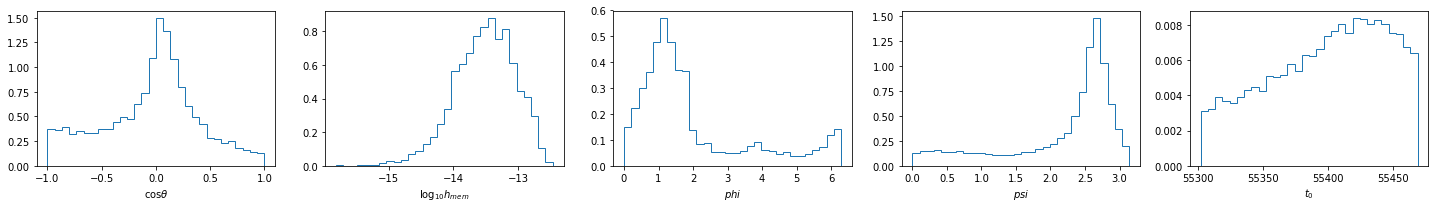

In [7]:
parz = [r'$\cos\theta$', r'$\log_{10}h_{mem}$', r'$phi$', r'$psi$', r'$t_0$']
hist_plot(chain_bwm, parz, cols=5,
          wid_per_col=4, kwargs={'color':'C0'});

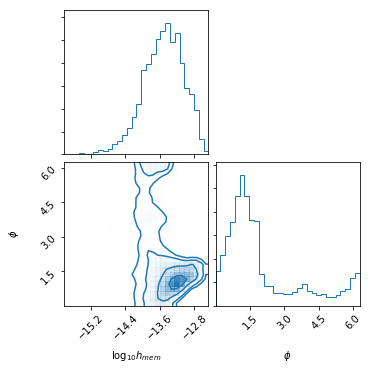

In [8]:
corner_kwargs = {'bins':30,
                 #'show_titles':True,
                 'labels':[r'$\log_{10} h_{mem}$', r'$\phi$'],
                 'smooth':0.75,
                 'plot_datapoints':False,
                 'plot_density':True,
                 'plot_contours':True,
                 'fill_contours':False,}

fig = corner(chain_bwm[:,1:3], color='C0', **corner_kwargs);

Now we resample the posterior ensuring we have the same number of samples in each source orientation bin

In [9]:
par_bwm

['bwm_costheta', 'bwm_log10_A', 'bwm_phi', 'bwm_pol', 'bwm_t0']

In [10]:
idx_ext = [idx_bwm[0], idx_bwm[2], idx_bwm[3]]

Nbins = 10
ch_ext = chain[:,idx_ext]
H, (xeds, yeds, zeds) = np.histogramdd(ch_ext, bins=Nbins, density=False)

Nsamp = 20
mySamp = []
for xx in range(Nbins-1):
    Xmask = np.logical_and(ch_ext[:,0]>xeds[xx], ch_ext[:,0]<xeds[xx+1])
    for yy in range(Nbins-1):
        Ymask = np.logical_and(ch_ext[:,1]>yeds[yy], ch_ext[:,1]<yeds[yy+1])
        for zz in range(Nbins-1):
            Zmask = np.logical_and(ch_ext[:,2]>zeds[zz], ch_ext[:,2]<zeds[zz+1])

            mask = np.logical_and(np.logical_and(Xmask, Zmask), Ymask)
            try:
                idx = np.random.choice(np.argwhere(mask).flat, size=Nsamp).flat
                mySamp.append(chain_bwm[idx])
            except:
                pass
ch_new = np.vstack(mySamp)



ch_new_mid = np.vstack(mySamp)
ch_bwm_mid = chain_bwm

orig -13.415991872470796
resamp -13.621891563152408


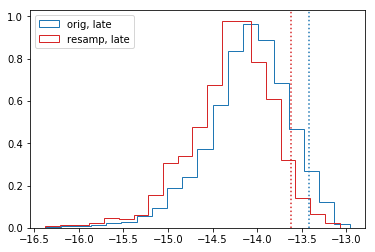

In [245]:
UL, dUL = UL_subsamp(ch_bwm_late[:, idx_A])
print('orig', UL)
plt.hist(ch_bwm_late[:, idx_A], bins=20, histtype='step', density=True, label='orig, late', color='C0');
plt.axvline(x=UL, ls=':', color='C0')

UL, dUL = UL_subsamp(ch_new_late[:, idx_A])
print('resamp', UL)
plt.hist(ch_new_late[:, idx_A], bins=20, histtype='step', density=True, label='resamp, late', color='C3');
plt.axvline(x=UL, ls=':', color='C3')
plt.legend()

orig -12.504562267799091
resamp -12.866771444968329


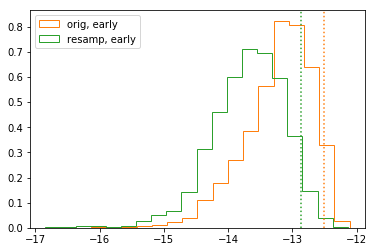

In [247]:
UL, dUL = UL_subsamp(ch_bwm_early[:, idx_A])
print('orig', UL)
plt.hist(ch_bwm_early[:, idx_A], bins=20, histtype='step', density=True, label='orig, early', color='C1');
plt.axvline(x=UL, ls=':', color='C1')

UL, dUL = UL_subsamp(ch_new_early[:, idx_A])
print('resamp', UL)
plt.hist(ch_new_early[:, idx_A], bins=20, histtype='step', density=True, label='resamp, early', color='C2');
plt.axvline(x=UL, ls=':', color='C2')
plt.legend()

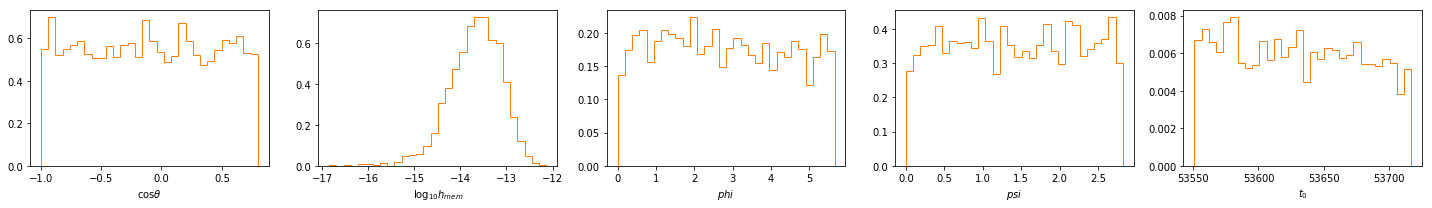

In [250]:
parz = [r'$\cos\theta$', r'$\log_{10}h_{mem}$', r'$phi$', r'$psi$', r'$t_0$']
hist_plot(ch_new_early, parz, cols=5,
          wid_per_col=4, kwargs={'color':'C1'});

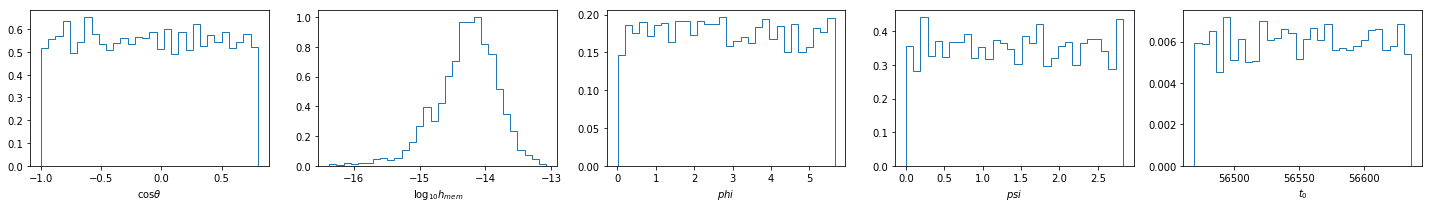

In [251]:
parz = [r'$\cos\theta$', r'$\log_{10}h_{mem}$', r'$phi$', r'$psi$', r'$t_0$']
hist_plot(ch_new_late, parz, cols=5,
          wid_per_col=4, kwargs={'color':'C0'});

## loop over all time bins and recalc the "re-normalized" UL

In [20]:
burnfrac = 0.15
thin = 50

ephems = ['DE436']
bayeseph_flags = [True, False]

figs = []

ULs = {}
dULs = {}

idx_ext = [idx_bwm[0], idx_bwm[2], idx_bwm[3]]
Nbins = 10
Nsamp = 20

for ephem in ephems:
    for bayesephem in bayeseph_flags:
        BE = '_BE' if bayesephem else ''
        key = ephem+BE
        print(key)
        ULs[key] = []
        dULs[key] = []

        for ts in tlim:
            tmin, cent, tmax = ts
            chunk = '{:.2f}'.format(cent)
            rundir = '/home/pbaker/nanograv/bwm/allsky_rerun/{0:s}/{1:s}/'.format(key, chunk)
            chain_raw = pd.read_csv(rundir + 'chain_1.txt',
                                    sep='\t', dtype=float, header=None).values
            burn = int(burnfrac * len(chain_raw))
            chain = chain_raw[burn::thin]
            chain_bwm = chain[:,idx_bwm]  # no ephem model

            corA = acor(chain_bwm[:,idx_A])[0]
            N = len(chain_bwm)

            # RESAMPLE
            ch_ext = chain[:,idx_ext]
            H, (xeds, yeds, zeds) = np.histogramdd(ch_ext, bins=Nbins, density=False)

            mySamp = []
            empty = 0
            for xx in range(Nbins-1):
                Xmask = np.logical_and(ch_ext[:,0]>xeds[xx], ch_ext[:,0]<xeds[xx+1])
                for yy in range(Nbins-1):
                    Ymask = np.logical_and(ch_ext[:,1]>yeds[yy], ch_ext[:,1]<yeds[yy+1])
                    for zz in range(Nbins-1):
                        Zmask = np.logical_and(ch_ext[:,2]>zeds[zz], ch_ext[:,2]<zeds[zz+1])

                        mask = np.logical_and(np.logical_and(Xmask, Zmask), Ymask)
                        try:
                            idx = np.random.choice(np.argwhere(mask).flat, size=Nsamp).flat
                            mySamp.append(chain_bwm[idx])
                        except:
                            empty += 1
                            costh = np.random.uniform(low=xeds[xx], high=xeds[xx+1], size=Nsamp)
                            phi = np.random.uniform(low=yeds[yy], high=yeds[yy+1], size=Nsamp)
                            psi = np.random.uniform(low=zeds[zz], high=zeds[zz+1], size=Nsamp)
                            t0 = np.random.uniform(low=tmin, high=tmax, size=Nsamp)
                            logh = -16
                            filler = np.array([costheta, logh, phi, psi, t0]).T
                            mySamp.append(filler)

            ch_new = np.vstack(mySamp)

            this_UL, this_dUL = UL_subsamp(10**ch_new[:,idx_A], p=0.95)
            ULs[key].append(this_UL)
            dULs[key].append(this_dUL)
            
            print("{:.2f}: N = {:d}, corr(A) = {:.2f}; Nempty = {:d}, h_mem < {:.3e}"
                  .format(cent, N, corA, empty, this_UL))
            
            figs.append(hist_plot(ch_new, par_bwm, cols=5, wid_per_col=2.5))

print('DONE!')

DE436_BE


NameError: name 'costheta' is not defined

In [15]:
from astropy.time import Time

Ts = np.array(tlim)[:,1]

Ts = Time(Ts, format='mjd').decimalyear

In [16]:
savedir = './ULvT_resamp3/'

!mkdir -p $savedir

cols = [k for k in ULs.keys()]
ULvt = np.vstack([u for u in ULs.values()])
dULvt = np.vstack([u for u in dULs.values()])

np.savetxt(savedir + '11yr_cols.dat', cols, fmt=b'%s')
np.savetxt(savedir + '11yr_UL.dat', ULvt)
np.savetxt(savedir + '11yr_dUL.dat', dULvt)
np.savetxt(savedir + '11yr_Ts.dat', Ts)

In [17]:
# save per chunk hists
outdir = "hists_"+key+"_resamp3"
!mkdir -p $outdir

for ii,fig in enumerate(figs):
    fig.savefig("hists_"+key+"/hist_{:02d}.png".format(ii))
    plt.close(fig)

Text(0, 0.5, '$95\\%$ UL (strain)')

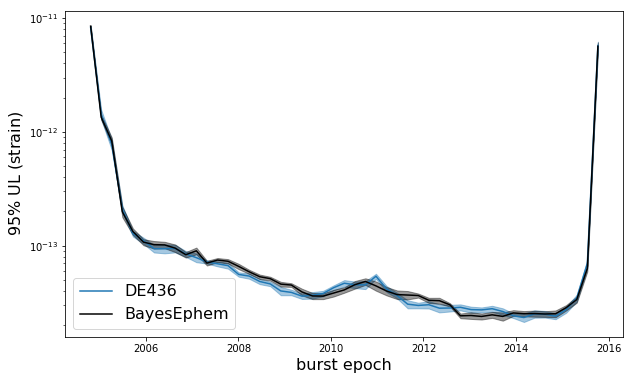

In [18]:
high = np.array(ULs['DE436']) + np.array(dULs['DE436'])
low = np.array(ULs['DE436']) - np.array(dULs['DE436'])

high_BE = np.array(ULs['DE436_BE']) + np.array(dULs['DE436_BE'])
low_BE = np.array(ULs['DE436_BE']) - np.array(dULs['DE436_BE'])

plt.close('all')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.fill_between(Ts, low, high, color='C0', alpha=0.4)
ax.plot(Ts, ULs['DE436'], color='C0', label='DE436')

ax.fill_between(Ts, low_BE, high_BE, color='k', alpha=0.4)
ax.plot(Ts, ULs['DE436_BE'], color='k', label='BayesEphem')


ax.legend(loc='lower left', fontsize=16)
ax.set_yscale('log')
ax.set_xlabel(r'burst epoch', fontsize=16)
ax.set_ylabel(r'$95\%$ UL (strain)', fontsize=16)

In [19]:
ii = np.argmin(ULs['DE436_BE'])
print(ii, Ts[ii], ULs['DE436_BE'][ii])

37 2013.2553424657535 2.3930208906041635e-14


In [253]:
# rerun
col_rerun = np.loadtxt('ULvT_rerun/11yr_cols.dat', dtype=str)
UL_rerun = np.loadtxt('ULvT_rerun/11yr_UL.dat')
dUL_rerun = np.loadtxt('ULvT_rerun/11yr_dUL.dat')
Ts_rerun = np.loadtxt('ULvT_rerun/11yr_Ts.dat')

# resamp for uniform sky & pol post
col_resamp = np.loadtxt('ULvT_resamp2/11yr_cols.dat', dtype=str)
UL_resamp = np.loadtxt('ULvT_resamp2/11yr_UL.dat')
dUL_resamp = np.loadtxt('ULvT_resamp2/11yr_dUL.dat')
Ts_resamp = np.loadtxt('ULvT_resamp2/11yr_Ts.dat')

# resamp w/ filler
col_resamp = np.loadtxt('ULvT_resamp3/11yr_cols.dat', dtype=str)
UL_resamp = np.loadtxt('ULvT_resamp3/11yr_UL.dat')
dUL_resamp = np.loadtxt('ULvT_resamp3/11yr_dUL.dat')
Ts_resamp = np.loadtxt('ULvT_resamp3/11yr_Ts.dat')

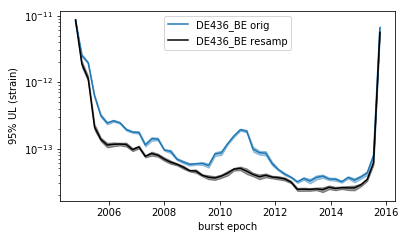

In [257]:
plt.figure(figsize=(6,3.5))

idx = list(col_rerun).index('DE436_BE')
high = np.array(UL_rerun[idx]) + np.array(dUL_rerun[idx])
low = np.array(UL_rerun[idx]) - np.array(dUL_rerun[idx])
plt.fill_between(Ts_rerun, low, high, color='C0', alpha=0.4)
plt.plot(Ts_rerun, UL_rerun[idx], label=col_rerun[idx]+' orig', color='C0')

idx = list(col_resamp).index('DE436_BE')
high = np.array(UL_resamp[idx]) + np.array(dUL_resamp[idx])
low = np.array(UL_resamp[idx]) - np.array(dUL_resamp[idx])
plt.fill_between(Ts_resamp, low, high, color='k', alpha=0.4)
plt.plot(Ts_resamp, UL_resamp[idx], label=col_resamp[idx]+' resamp', color='k')


plt.yscale('log')
plt.xlabel(r'burst epoch')
plt.ylabel(r'$95\%$ UL (strain)')
plt.legend()

## resamp with filler data!

In [294]:
tmin, tmax = np.min(chain_bwm[:,idx_t0]), np.max(chain_bwm[:,idx_t0])

idx_ext = [idx_bwm[0], idx_bwm[2], idx_bwm[3]]

Nbins = 10
ch_ext = chain[:,idx_ext]
H, (xeds, yeds, zeds) = np.histogramdd(ch_ext, bins=Nbins, density=False)

Nsamp = 20
mySamp = []
for xx in range(Nbins-1):
    Xmask = np.logical_and(ch_ext[:,0]>xeds[xx], ch_ext[:,0]<xeds[xx+1])
    for yy in range(Nbins-1):
        Ymask = np.logical_and(ch_ext[:,1]>yeds[yy], ch_ext[:,1]<yeds[yy+1])
        for zz in range(Nbins-1):
            Zmask = np.logical_and(ch_ext[:,2]>zeds[zz], ch_ext[:,2]<zeds[zz+1])

            mask = np.logical_and(np.logical_and(Xmask, Zmask), Ymask)
            try:
                idx = np.random.choice(np.argwhere(mask).flat, size=Nsamp).flat
                mySamp.append(chain_bwm[idx])
            except:
                costheta = np.random.uniform(low=xeds[xx], high=xeds[xx+1], size=Nsamp)
                phi = np.random.uniform(low=yeds[yy], high=yeds[yy+1], size=Nsamp)
                psi = np.random.uniform(low=zeds[zz], high=zeds[zz+1], size=Nsamp)
                t0 = np.random.uniform(low=tmin, high=tmax, size=Nsamp)
                logh = np.random.normal(-16, 1, size=Nsamp)
                filler = np.array([costheta, logh, phi, psi, t0]).T
                mySamp.append(filler)
ch_new = np.vstack(mySamp)



ch_new_filler = np.vstack(mySamp)

orig -12.809520567783375
resamp -13.31453372790097
filler -13.343678921686804


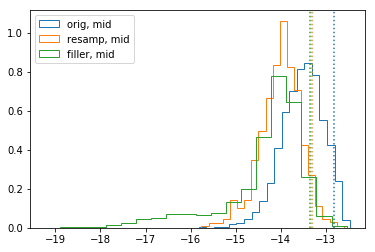

In [295]:
UL, dUL = UL_subsamp(ch_bwm_mid[:, idx_A])
print('orig', UL)
plt.hist(ch_bwm_mid[:, idx_A], bins=20, histtype='step', density=True, label='orig, mid', color='C0');
plt.axvline(x=UL, ls=':', color='C0')

UL, dUL = UL_subsamp(ch_new_mid[:, idx_A])
print('resamp', UL)
plt.hist(ch_new_mid[:, idx_A], bins=20, histtype='step', density=True, label='resamp, mid', color='C1');
plt.axvline(x=UL, ls=':', color='C1')
plt.legend()

UL, dUL = UL_subsamp(ch_new_filler[:, idx_A])
print('filler', UL)
plt.hist(ch_new_filler[:, idx_A], bins=20, histtype='step', density=True, label='filler, mid', color='C2');
plt.axvline(x=UL, ls=':', color='C2')
plt.legend()